- [ ]  Does graphblas require conda? 
- can install on pip or conda...Tried to confirm in venv w/ pip install but it got hung up on build wheels for suitesparse-graphblas (i think it's user error?)

- test it in Panel
  - they have graphM (object), and graph algorithms, basically hierarchical series/dataframe  
- if this all works, can use for Grabble underlying data storage  


- Need to decide if we want to use their algorithms (which use graph objects), how to work with networkx  


-  Test out semiring operations (Tropical semiring/breadth-first search will be foundation of grabble operations)

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import networkx as nx
import matplotlib.pyplot as plt
# import janitor as jn
# import sparse as sprs

import ipywidgets

In [2]:
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import unary, binary, monoid, semiring
from graphblas import dtypes

In [3]:
G = nx.random_graphs.connected_watts_strogatz_graph(25, 4, 0.7)

nx.set_edge_attributes(G, values = 1, name = 'weight')
nx.set_node_attributes(G, nx.pagerank(G), name='importance')

In [4]:
G[0]

AtlasView({21: {'weight': 1}, 12: {'weight': 1}, 7: {'weight': 1}})

In [5]:
G.nodes[0]

{'importance': 0.030421750966477396}

In [6]:
G.edges

EdgeView([(0, 21), (0, 12), (0, 7), (1, 2), (1, 24), (1, 7), (2, 4), (2, 16), (3, 6), (3, 19), (3, 16), (3, 15), (4, 23), (4, 18), (4, 14), (4, 6), (4, 12), (4, 16), (5, 6), (5, 7), (6, 14), (7, 8), (7, 16), (8, 17), (8, 21), (8, 9), (8, 14), (9, 10), (9, 13), (9, 23), (10, 11), (10, 12), (11, 16), (11, 21), (12, 13), (12, 17), (12, 24), (13, 20), (14, 24), (15, 20), (16, 21), (17, 19), (18, 20), (19, 21), (20, 21), (20, 22), (21, 24), (22, 23), (22, 24), (23, 24)])

In [7]:
# Create initial data objects
edges = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
]
A_example = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
s = 1

Refer to code: **Example B.1 Level Breadth-first Search**:
 https://github.com/python-graphblas/python-graphblas/blob/main/notebooks/Example%20B.1%20--%20Level%20BFS.ipynb

In [8]:
A = gb.io.from_networkx(G)

In [9]:
A

"M_1"      nvals  nrows  ncols  dtype     format
gb.Matrix    100     25     25  INT64  csr (iso)
------------------------------------------------
   0  1  2  3  4  5  6  7  8  9   ... 15 16 17 18 19 20 21 22 23 24
0                        1        ...                    1         
1         1              1        ...                             1
2      1        1                 ...     1                        
3                     1           ...  1  1        1               
4         1           1           ...     1     1              1   
5                     1  1        ...                              
6            1  1  1              ...                              
7   1  1           1        1     ...     1                        
8                        1     1  ...        1           1         
9                           1     ...                          1   
10                             1  ...                              
11                                ...     1              1         
12  1           1                 ...        1                    1
13                             1  ...                 1            
14              1     1     1     ...                             1
15           1                    ...                 1            
16        1  1  1        1        ...                    1         
17                          1     ...              1               
18              1                 ...                 1            
19           1                    ...        1           1         
20                                ...  1        1        1  1      
21  1                       1     ...     1        1  1           1
22                                ...                 1        1  1
23              1              1  ...                       1     1
24     1                          ...                    1  1  1

In [10]:
A_example

"M_0"      nvals  nrows  ncols  dtype         format
gb.Matrix     12      7      7   BOOL  bitmapr (iso)
----------------------------------------------------
      0     1     2     3     4     5     6
0        True        True                  
1                          True        True
2                                True      
3  True        True                        
4                                True      
5              True                        
6              True  True  True

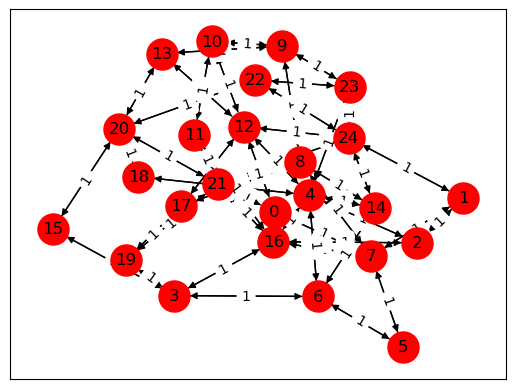

In [11]:
gb.viz.draw(A)

In [12]:
n = A.nrows
v = Vector(dtypes.INT32, n)
q = Vector(bool, n)
q[s] << True
succ = Scalar(bool)

In [13]:
d = 0  # level in BFS traversal
while True:
    d += 1
    # For the frontier, assign the depth level
    v[:](mask=q.V) << d
    # Compute the next frontier, masking out anything already assigned
    q(~v.S, replace=True) << q.vxm(A, semiring.lor_land)
    # If next frontier is empty, we're done
    succ << q.reduce(monoid.lor, allow_empty=False)
    if not succ:
        break
v

"v_0"      nvals  size  dtype  format
gb.Vector     25    25  INT32    full
-------------------------------------
index 0  1  2  3  4  5  6  7  8  9   ... 15 16 17 18 19 20 21 22 23 24
value  3  1  2  4  3  3  4  2  3  4  ...  5  3  4  4  4  4  3  3  3  2

In [14]:
# Only run this cell once -- it initializes things
v.clear()
q.clear()
q[s] << True
d = 0

In [27]:
d += 1

# For the frontier, assign the depth level

v[:](mask=q.V) << d
v

"v_0"      nvals  size  dtype  format
gb.Vector     25    25  INT32    full
-------------------------------------
index 0  1  2  3  4  5  6  7  8  9   ... 15 16 17 18 19 20 21 22 23 24
value  3  1  2  4  3  3  4  2  3  4  ...  5  3  4  4  4  4  3  3  3  2

In [28]:
# Compute the next frontier, masking out anything already assigned
q(~v.S, replace=True) << q.vxm(A, semiring.lor_land)
q
# These are the next layer of the BFS, prep'd for the next iteration

"v_1"      nvals  size  dtype  format
gb.Vector      0    25   BOOL  sparse
-------------------------------------
index 0  1  2  3  4  5  6  7  8  9   ... 15 16 17 18 19 20 21 22 23 24
value                                ...

In [29]:
succ << q.reduce(monoid.lor, allow_empty=False)
print("Continue" if succ else "Done")

Done
